In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
from utils import load_mnist
from trainer import Trainer

In [4]:
from argparse import Namespace

config = {
    'train_ratio': .8,
    'batch_size':256,
    'n_epochs': 50,
    'verbose': 1,
    'btl_size': 2
}

config = Namespace(**config)
print(config)

Namespace(train_ratio=0.8, batch_size=256, n_epochs=50, verbose=1, btl_size=2)


In [5]:
# 이미지를 출력하는 함수
def show_image(x):
    if x.dim() == 1:
        x = x.view(int(x.size(0) ** .5), -1) # (28*28)^{0.5} = 28, 즉 (28, 28) shape으로 만들라는 뜻
        
    plt.imshow(x, cmap='gray')
    plt.show()

In [6]:
train_x, train_y = load_mnist(flatten=True)
test_x, test_y = load_mnist(is_train=False, flatten=True)

train_cnt = int(train_x.size(0) * config.train_ratio)
valid_cnt = train_x.size(0) - train_cnt

# Shuffle dataset to split into train/valid set.
indices = torch.randperm(train_x.size(0))
train_x, valid_x = torch.index_select(
    train_x,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)

train_y, valid_y = torch.index_select(
    train_y,
    dim=0,
    index=indices
).split([train_cnt, valid_cnt], dim=0)

print("Train:", train_x.shape, train_y.shape)
print("Valid:", valid_x.shape, valid_y.shape)
print("Test:", test_x.shape, test_y.shape)

Train: torch.Size([48000, 784]) torch.Size([48000])
Valid: torch.Size([12000, 784]) torch.Size([12000])
Test: torch.Size([10000, 784]) torch.Size([10000])


In [7]:
from model import Autoencoder

In [8]:
model = Autoencoder(btl_size=config.btl_size)
optimizer = optim.Adam(model.parameters())
crit = nn.MSELoss()

trainer = Trainer(model, optimizer, crit)

In [9]:
trainer.train((train_x, train_x), (valid_x, valid_x), config)

Epoch(1/50): train_loss=0.0747 valid_loss=0.0507 lowest_loss=0.0507
Epoch(2/50): train_loss=0.0486 valid_loss=0.0461 lowest_loss=0.0461
Epoch(3/50): train_loss=0.0455 valid_loss=0.0435 lowest_loss=0.0435
Epoch(4/50): train_loss=0.0441 valid_loss=0.0432 lowest_loss=0.0432
Epoch(5/50): train_loss=0.0433 valid_loss=0.0421 lowest_loss=0.0421
Epoch(6/50): train_loss=0.0427 valid_loss=0.0426 lowest_loss=0.0421
Epoch(7/50): train_loss=0.0423 valid_loss=0.0426 lowest_loss=0.0421
Epoch(8/50): train_loss=0.0418 valid_loss=0.0404 lowest_loss=0.0404
Epoch(9/50): train_loss=0.0414 valid_loss=0.0408 lowest_loss=0.0404
Epoch(10/50): train_loss=0.0409 valid_loss=0.0403 lowest_loss=0.0403
Epoch(11/50): train_loss=0.0409 valid_loss=0.0394 lowest_loss=0.0394
Epoch(12/50): train_loss=0.0403 valid_loss=0.0399 lowest_loss=0.0394
Epoch(13/50): train_loss=0.0404 valid_loss=0.0393 lowest_loss=0.0393
Epoch(14/50): train_loss=0.0399 valid_loss=0.0387 lowest_loss=0.0387
Epoch(15/50): train_loss=0.0399 valid_loss=

# Test

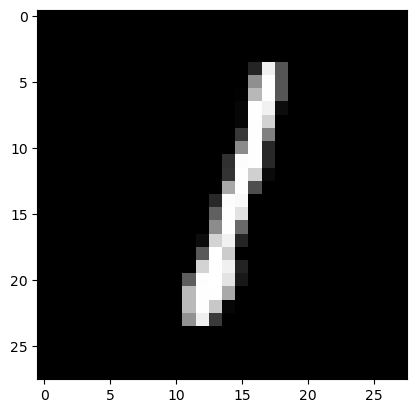

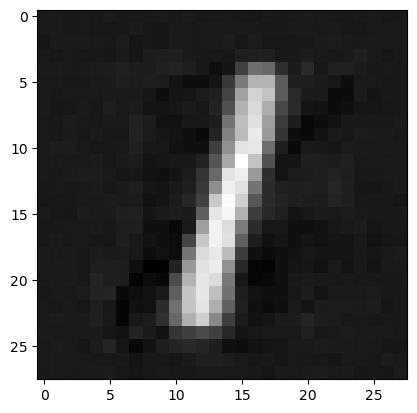

In [10]:
with torch.no_grad():
    import random
    
    index = int(random.random() * test_x.size(0))
    
    recon = model(test_x[index].view(1, -1)).squeeze()
    
    show_image(test_x[index])
    show_image(recon)

# Latent Space

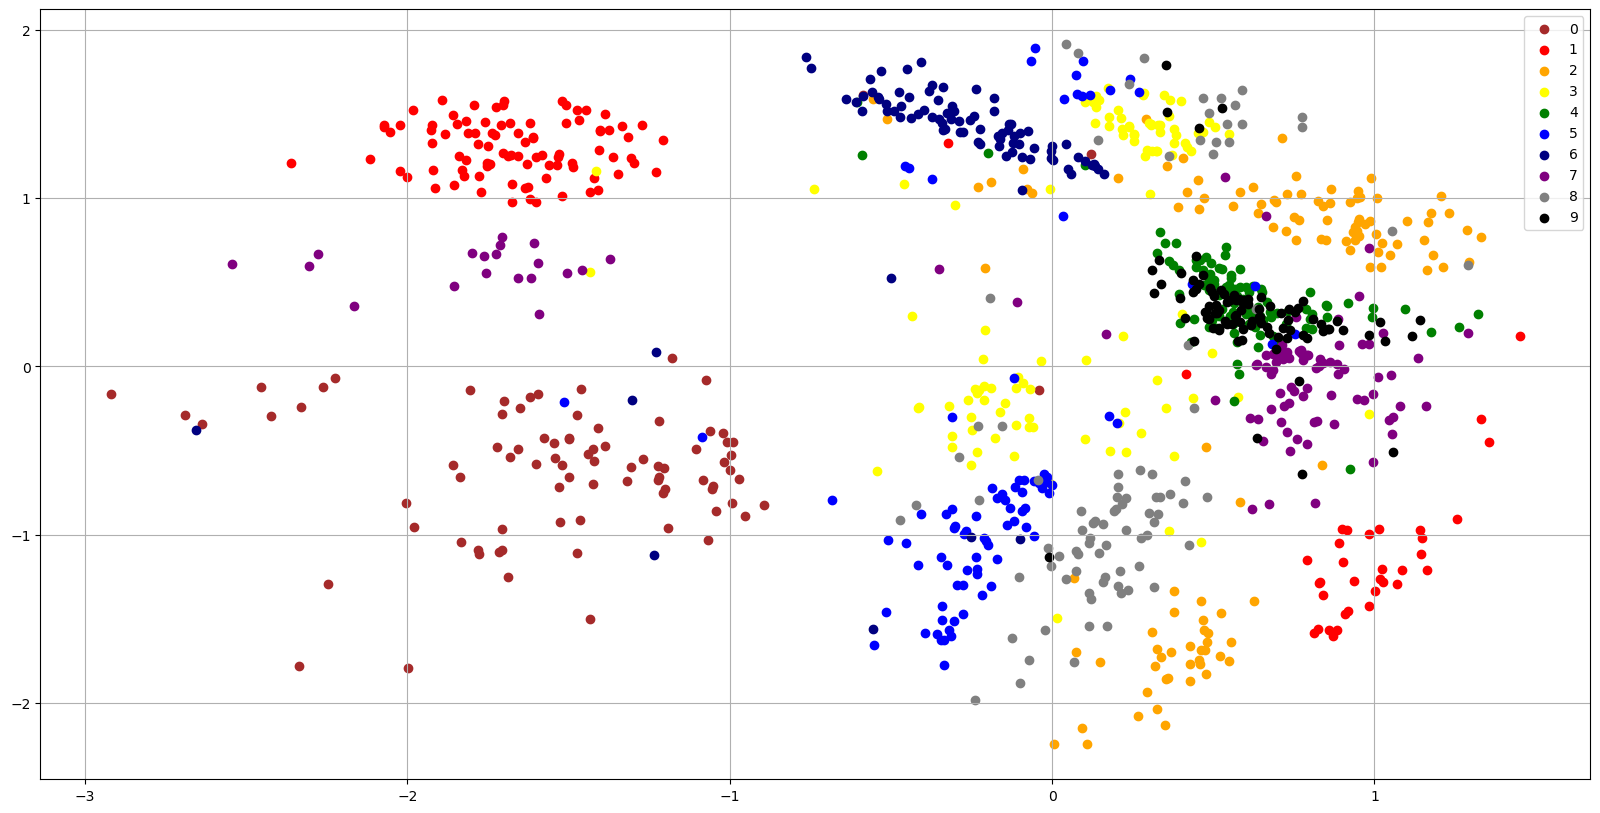

In [14]:
if config.btl_size == 2: # 2차원으로 해야 시각화가 원활하기 때문
    # 10개의 각 class에 색을 정한다. 
    color_map = [ 
        'brown', 'red', 'orange', 'yellow', 'green',
        'blue', 'navy', 'purple', 'gray', 'black',
    ]
    
    plt.figure(figsize=(20, 10)) # map size
    with torch.no_grad():
        latents = model.encoder(test_x[:1000]) # encoder를 통과해 z를 받는다.
        
        for i in range(10):
            target_latents = latents[test_y[:1000] == i] # 각 class의 잠재 공간의 값을 가져온다.
            target_y = test_y[:1000][test_y[:1000] == i] 
            # 시각화
            # x, y : The data positions.
            plt.scatter(target_latents[:, 0], # x 좌표
                        target_latents[:, 1], # y 좌표 
                        marker='o',
                        color=color_map[i],
                        label=i)
            
        plt.legend()
        plt.grid(axis='both')
        plt.show()
                        

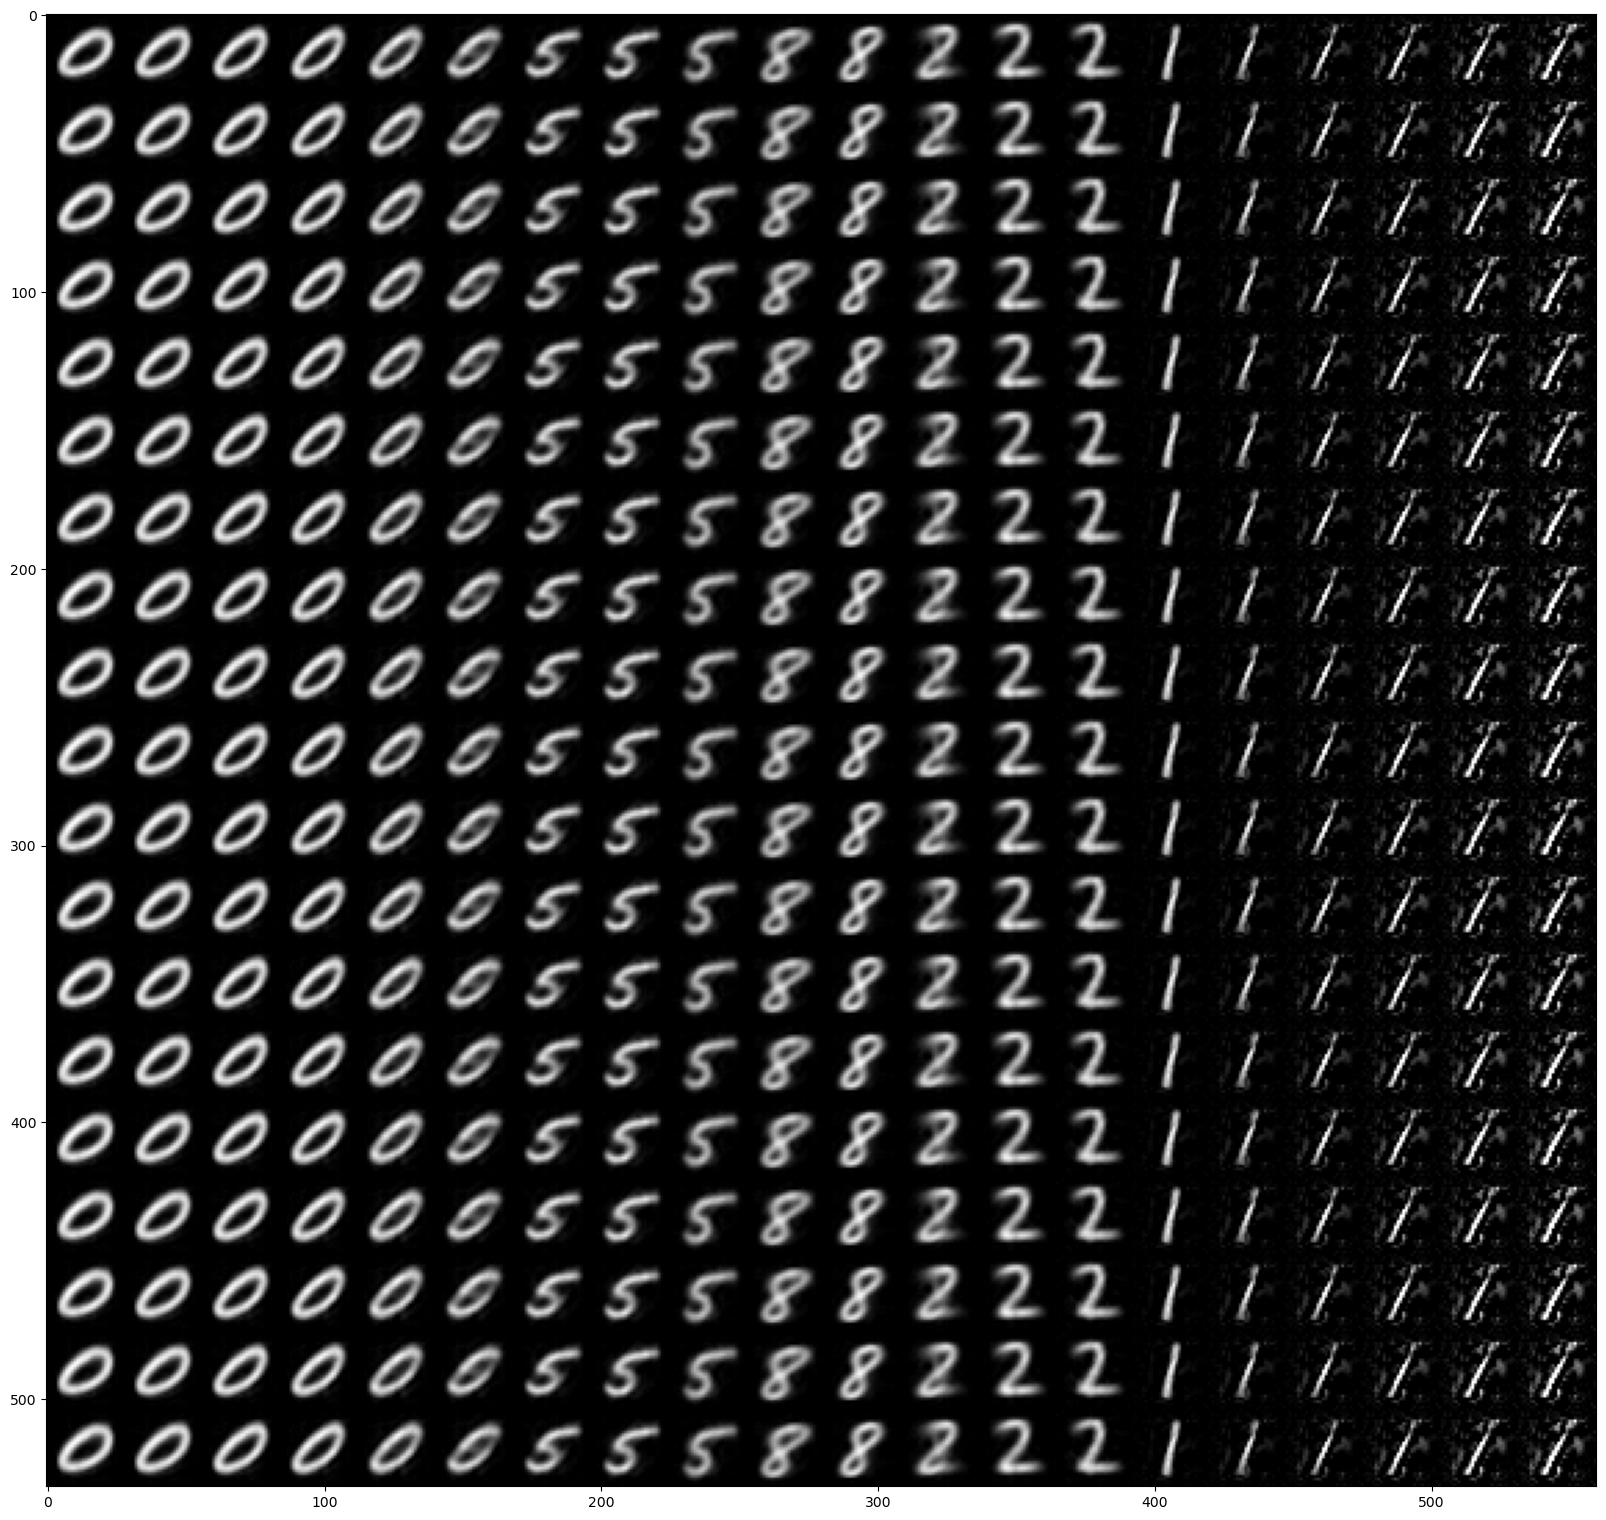

In [16]:
# 코드 뜯어 보면서 주석 처리할 것

if config.btl_size == 2:
    min_range, max_range = -2. , 2. #
    n = 20 #
    step = (max_range - min_range) / float(n) # 4/20 = 1/5 = .2 # 무슨 의미?
    
    with torch.no_grad():
        lines = []
        
        for v1 in np.arange(min_range, max_range, step): # -2~ 1까지 0.2씩 증가
            # latent Tensor
            z = torch.stack([
                torch.FloatTensor([v1] * n), # [v1, v1, ... ,v1] = len() = 20
                torch.FloatTensor([v2 for v2 in np.arange(min_range, max_range, step)]),
            ], dim=-1)
            
            line = torch.clamp(model.decoder(z).view(n, 28, 28), 0, 1)
            line = torch.cat([line[1] for i in range(n -1, 0, -1)], dim=0)
            lines += [line]
            
        lines = torch.cat(lines, dim=-1)
        plt.figure(figsize=(20, 20))
        show_image(lines)